## Importing Libraries

In [ ]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, RepeatVector, TimeDistributed, Flatten
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization


from sklearn.preprocessing import MinMaxScaler, StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

### Importing Dataset

In [ ]:
# Downloading the data
stock_name = 'JNJ'
aapl_df = yf.download(stock_name)
aapl_df.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.0,0.223380,0.222222,0.223380,0.065487,0
1962-01-03,0.0,0.221065,0.219907,0.219907,0.064469,345600
1962-01-04,0.0,0.221065,0.217593,0.217593,0.063790,216000
1962-01-05,0.0,0.215856,0.214120,0.214120,0.062772,129600
1962-01-08,0.0,0.212384,0.210648,0.210648,0.061754,172800
1962-01-09,0.0,0.212963,0.212963,0.212963,0.062433,43200
1962-01-10,0.0,0.217593,0.214699,0.217593,0.063790,172800
1962-01-11,0.0,0.217593,0.216435,0.216435,0.063451,172800
1962-01-12,0.0,0.217593,0.214120,0.214120,0.062772,259200


### Data Preprocessing

In [ ]:
# Adding a column 'Prediction' which is shifted by 1 day
aapl_df['Prediction'] = aapl_df['Close'].shift(-1)

# Removing NA values
aapl_df = aapl_df.dropna()
aapl_df.drop('Adj Close', axis=1, inplace=True)

aapl_df.head()

<ipython-input-8-9060654c1949>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aapl_df.drop('Adj Close', axis=1, inplace=True)


,Open,High,Low,Close,Volume,Prediction
Date,,,,,,
1962-01-02,0.0,0.223380,0.222222,0.223380,0,0.219907
1962-01-03,0.0,0.221065,0.219907,0.219907,345600,0.217593
1962-01-04,0.0,0.221065,0.217593,0.217593,216000,0.214120
1962-01-05,0.0,0.215856,0.214120,0.214120,129600,0.210648
1962-01-08,0.0,0.212384,0.210648,0.210648,172800,0.212963


In [ ]:
# Extract dates for the test dataset
x_date = aapl_df.index[-math.floor(len(aapl_df) * 0.2):]

In [ ]:
in_scaler = MinMaxScaler()
out_scaler = MinMaxScaler()

# Scaling the data
x = in_scaler.fit_transform(aapl_df.drop(['Prediction'], axis=1))
# y = out_scaler.fit_transform(aapl_df.drop(
#     ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1))
y = out_scaler.fit_transform(aapl_df.drop(
    ['Open', 'High', 'Low', 'Close', 'Volume'], axis=1))

### Creating Dataset

In [ ]:
sequence_length = 42
train_len = math.ceil(len(aapl_df) * 0.6)
val_len = math.ceil(len(aapl_df) * 0.2)

# Splitting the data into train, validation and test dataset
x_train = x[:train_len, :]
y_train = y[:train_len, :]

x_val = x[train_len - sequence_length:train_len + val_len, :]
y_val = y[train_len - sequence_length:train_len + val_len, :]

x_test = x[train_len + val_len - sequence_length:, :]
y_test = y[train_len + val_len - sequence_length:, :]

In [ ]:
def create_dataset(x, y, sequence_length):
    x_data = []
    y_data = []
    for i in range(sequence_length, len(x)):
        x_data.append(x[i - sequence_length:i, :])
        y_data.append(y[i, :])
    return np.array(x_data), np.array(y_data)


# Creating the dataset
x_train, y_train = create_dataset(x_train, y_train, sequence_length)
x_val, y_val = create_dataset(x_val, y_val, sequence_length)
x_test, y_test = create_dataset(x_test, y_test, sequence_length)

## Model Building and Training

In [ ]:
def CNNLSTM():
  model = Sequential()
  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  n_neurons = x_train.shape[1] * x_train.shape[2]
  print(n_neurons, x_train.shape[1], x_train.shape[2])
  model.add(Conv1D(filters=n_neurons, kernel_size=3, activation='relu', input_shape=(sequence_length, x_train.shape[2])))
  # model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
  model.add(LSTM(units=n_neurons, return_sequences=True))
  # model.add(Dropout(0.2))
  model.add(LSTM(units=n_neurons))
  model.add(Dense(6))
  model.add(Dense(1))
  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='mse')
  return model

In [ ]:
# def CNNLSTM():
#     model = Sequential()
#     n_neurons = x_train.shape[1] * x_train.shape[2]

#     # Convolutional layer
#     model.add(Conv1D(filters=n_neurons, kernel_size=3, activation='relu', input_shape=(sequence_length, x_train.shape[2])))
#     # model.add(BatchNormalization())

#     # LSTM layers
#     model.add(LSTM(units=n_neurons, return_sequences=True))
#     # model.add(Dropout(0.2))
#     model.add(LSTM(units=n_neurons))

#     # Dense layers
#     model.add(Dense(6, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))

#     # Compile the model
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

#     return model

In [ ]:
model = CNNLSTM()
model.summary()

210 42 5
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 40, 210)           3360      
                                                                 
 lstm_24 (LSTM)              (None, 40, 210)           353640    
                                                                 
 lstm_25 (LSTM)              (None, 210)               353640    
                                                                 
 dense_24 (Dense)            (None, 6)                 1266      
                                                                 
 dense_25 (Dense)            (None, 1)                 7         
                                                                 
Total params: 711,913
Trainable params: 711,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
# checkpoint = ModelCheckpoint('cnnlstm.h5',
#                              monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# epochs = 100
# batch_size = 16

# history = model.fit(
#     x_train, y_train,
#     epochs=epochs,
#     batch_size=batch_size,
#     validation_data=(x_val, y_val),
#     callbacks=[early_stopping, checkpoint],
# )

## Model Evaluation

In [ ]:
model = CNNLSTM()
try:
  model.load_weights('CNNLSTM_AAPL.h5')
except Exception as e:
  print(e)
  model.load_weights('cnnlstm.h5')

210 42 5


In [ ]:
# !pip install tf-explain
# !pip install opencv-python

In [ ]:
# from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback

# # Define the IntegratedGradientsCallback with class_index=0
# integrated_gradients_callback = IntegratedGradientsCallback(validation_data=(x_val, y_val), class_index=0)

# # Train the model with the IntegratedGradientsCallback
# model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[integrated_gradients_callback])


In [ ]:
predicitons = model.predict(x_test)
predicitons.shape

83/83 [==============================] - 1s 5ms/step


(2641, 1)

In [ ]:
predictions = model.predict(x_test)
predictions = out_scaler.inverse_transform(predictions)
actual = out_scaler.inverse_transform(y_test)

# Calculating the error
error = predictions - actual
mse = np.square(error).mean()
rmse = np.sqrt(mse)
mae = np.abs(error).mean()
mape = np.abs(error / actual).mean() * 100

# Printing the error
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Mean Absolute Percentage Error: ', mape)

83/83 [==============================] - 0s 4ms/step
Mean Squared Error:  100748.72144106496
Root Mean Squared Error:  317.40939091505305
Mean Absolute Error:  256.8128519285723
Mean Absolute Percentage Error:  3.394090527925248


## Model Prediction and Visualization

In [ ]:
actual.flatten().shape

(2641,)

In [ ]:
predictions.flatten().shape

(2641,)

In [ ]:
x_date.shape

(2641,)

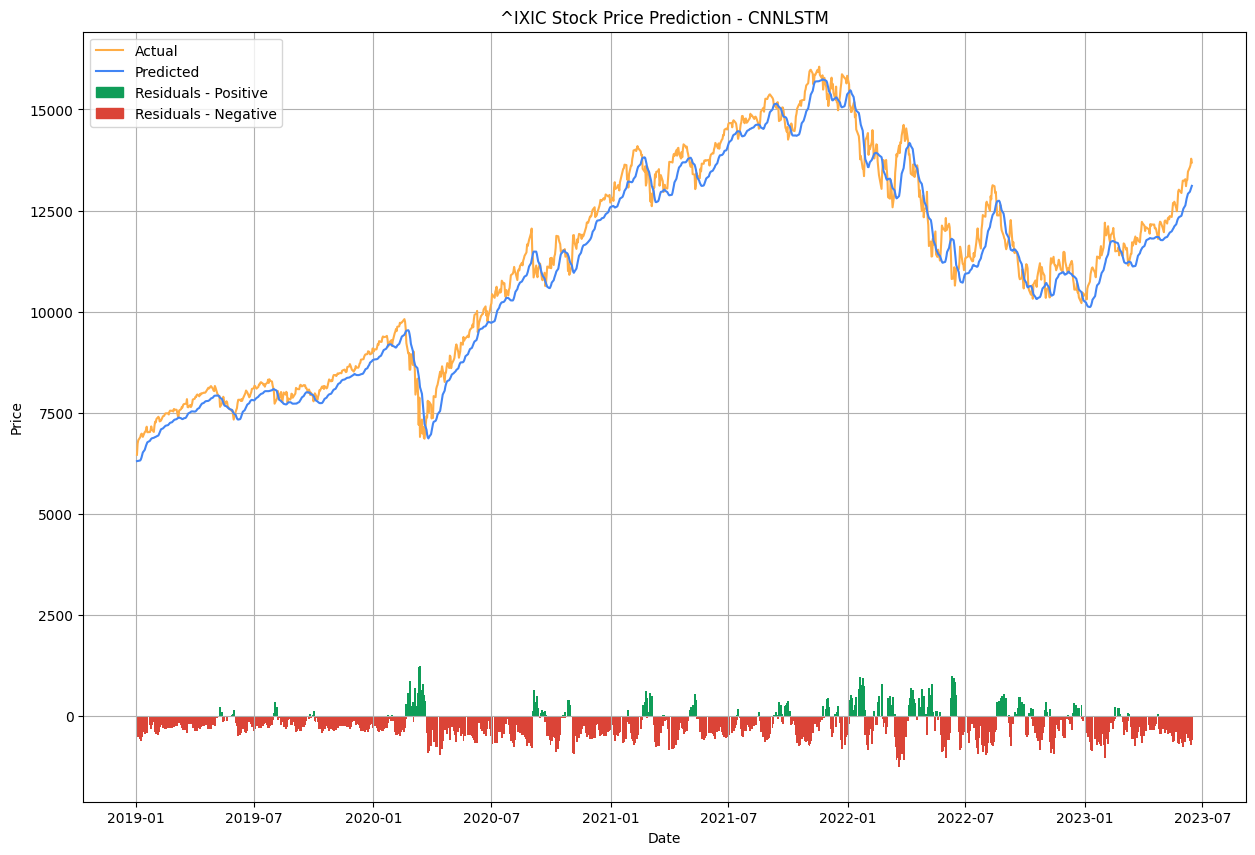

In [ ]:
# Creating a dataframe for the predictions, actual values and residuals
prediction_df = pd.DataFrame({'Actual': actual.flatten(
), 'Predicted': predictions.flatten(), 'Residuals': error.flatten()}, index=x_date[:])

# Taking data from 2019-01-01
predictions_df = prediction_df.loc['2019-01-01':]

# Plotting the data and residuals bars in the same plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(predictions_df.index,
        predictions_df['Actual'], label='Actual', color='#FFAD46', linewidth=1.5)
ax.plot(predictions_df.index,
        predictions_df['Predicted'], label='Predicted', color='#4285F4', linewidth=1.5)

df_sub = ["#0F9D58" if x >
          0 else "#DB4437" for x in predictions_df["Residuals"].dropna()]
ax.bar(predictions_df.index, predictions_df['Residuals'].dropna(
), width=3, label='Residuals', color=df_sub)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title(f'{stock_name} Stock Price Prediction - CNNLSTM')

Patch = mpatches.Patch
legend_elements = [Line2D([0], [0], color='#FFAD46', lw=1.5, label='Actual'),
                   Line2D([0], [0], color='#4285F4',
                          lw=1.5, label='Predicted'),
                   Patch(facecolor='#0F9D58', edgecolor='#0F9D58',
                         label='Residuals - Positive'),
                   Patch(facecolor='#DB4437', edgecolor='#DB4437', label='Residuals - Negative')]
ax.legend(handles=legend_elements, loc='upper left')

ax.grid(True)
plt.show()

In [ ]:
# model.save('mslstm_model.h5')